# VRPTW - M3AS

In [1]:
import os
!pip install paretoset
from paretoset import paretoset
import numpy as np
from tqdm.notebook import trange, tqdm

In [2]:
class Cliente:
    def __init__(self, numero, x, y, demanda, inicio, fin, tiempo):
        self.numero = int(float(numero))
        self.x = float(x)
        self.y = float(y)
        self.demanda = float(demanda)
        self.inicio = float(inicio)
        self.fin = float(fin)
        self.tiempo = float(tiempo)

    @property
    def coords(self):
        return np.array([self.x, self.y])

In [3]:
# Preprocesar los datos de entrada
def procesar_instancia(filename):
    with open(filename, "r") as f:
        lineas = f.readlines()

    # Obtener clientes y capacidad
    clientes = int(lineas[1])
    capacidad = int(lineas[3])

    # Obtener por cada cliente los datos
    lista = []
    for cliente in lineas[5:]:
        lista.append(Cliente(*cliente.strip().split()))

    return capacidad, lista

In [4]:
capacidad_c101, clientes_c101 = procesar_instancia("datos/original/vrptw_c101.txt")
capacidad_rc101, clientes_rc101 = procesar_instancia("datos/original/vrptw_rc101.txt")

In [5]:
capacidad = capacidad_c101
clientes = clientes_c101
num_clientes = len(clientes)

In [6]:
def hallar_tiempo(i: int, j: int):
    return np.linalg.norm(clientes[i].coords - clientes[j].coords)

In [7]:
class Solucion:

    def __init__(self):
        self.visitados = np.zeros(num_clientes, dtype=np.bool8)
        self.visitados[0] = True
        self.caminos = [[]]
        self.tiempo_actual = 0
        self.consumo_capacidad = 0

    @property
    def num_vehiculos(self):
        return len(self.caminos)

    @property
    def nodo_actual(self):
        if len(self.caminos[-1]) > 0:
            _ , actual = self.caminos[-1][-1]
        else:
            actual = 0
        return actual

    def camino_en_vehiculo(self, i):
        return self.caminos[i]

    @property
    def completo(self):
        return False not in self.visitados

    @property
    def siguientes_nodos(self):
        i = self.nodo_actual
        no_visitados = np.where(self.visitados == False)[0]
        siguientes_j = []

        for j in no_visitados:
            # Verificar que cumpla la ventana
            tiempo = hallar_tiempo(i, j)
            tiempo_al_llegar = max(self.tiempo_actual + tiempo, clientes[j].inicio)
            
            if tiempo_al_llegar + clientes[j].tiempo > clientes[j].fin:
                continue # No va a poder atenderle antes del cierre
            
            # Verificar que cumpla la capacidad del vehiculo
            if self.consumo_capacidad + clientes[j].demanda > capacidad:
                continue # Supera la capacidad

            # Se puede visitar
            siguientes_j.append(j)

        return siguientes_j

    def agregar_camino(self, j):
        # El sumamos al tiempo lo que cuesta llegar hasta j y su servicio (se incluye la espera si llega antes)
        self.tiempo_actual = max(hallar_tiempo(self.nodo_actual, j) + self.tiempo_actual, clientes[j].inicio) + clientes[j].tiempo
        self.visitados[j] = True
        self.consumo_capacidad = self.consumo_capacidad + clientes[j].demanda
        camino = (self.nodo_actual, j)
        self.caminos[-1].append( camino )

    def agregar_vehiculo(self):
        self.caminos.append([])
        self.tiempo_actual = 0
        self.consumo_capacidad = 0

    @property
    def tiempo_total(self):
        """
        Evalua el tiempo recorrido sin tener en cuenta el tiempo esperado
        """
        tiempo = 0.0
        for vehiculo in self.caminos:
            for viaje in vehiculo:
                tiempo = tiempo + hallar_tiempo(*viaje)

        return tiempo

In [8]:
m = 100
shape = (num_clientes, num_clientes)
p = 0.7
beta = 0.7


In [9]:
tabla_t = np.full(shape, 1.0) # T_i,j
tabla_n_2 = np.empty(shape) # N_i,j

# Inicializar visibilidad de tiempo
for i in range(num_clientes):
    for j in range(num_clientes):
        tabla_n_2[i,j] = 1.0 / hallar_tiempo(i,j) if hallar_tiempo(i,j) > 0 else 1

In [10]:
# Calcular Función Objetivo delta t
norm_vehiculo = 10
norm_tiempo = 820.0

def feromona_a_depositar(solucion: Solucion):
    return 1 / (solucion.num_vehiculos / norm_vehiculo + solucion.tiempo_total / norm_tiempo)

In [11]:
# Tmax
def t_max_calculado(feromona: float):
    return feromona / (1 - p)

def t_min_calculado(t_max: float):
    return t_max / 2 / m

In [12]:
def feromona_calculada(i, j):
    visibilidades = tabla_n_2[i, j] 
    return tabla_t[i,j] * (visibilidades ** beta )

$$
p_{i,j} =
\begin{cases} 
      \frac{\tau_{i,j} \left[ n_{i,j}^0 \right]^{\lambda \beta} \left[ n_{i,j}^1 \right]^{(1-\lambda) \beta}}
      {\sum_{x \in J_i} \tau_{i,x} \left[ n_{i,x}^0 \right]^{\lambda \beta} \left[ n_{i,x}^1 \right]^{(1-\lambda) \beta}} & \text{si } j \in J_i \\
     0 & \text{ en caso contrario}
\end{cases}
$$

In [13]:
def probabilidades_transicion(i: int, nodos: [int]):
    probabilidades = np.array([ feromona_calculada(i,j) for j in nodos ])
    total_probabilidades = probabilidades.sum()
    return probabilidades / total_probabilidades

In [14]:
def seleccionar_siguiente_estado(solucion: Solucion):
    # Seleccionar siguiente nodo con distribución de probabilidad
    nodos_factibles = solucion.siguientes_nodos

    if len(nodos_factibles) > 0: # Hay nodos
        return np.random.choice(nodos_factibles, p=probabilidades_transicion(solucion.nodo_actual, nodos_factibles))
    else:
        # Ya es muy tarde o ya atendió su capacidad máxima
        return 0 # Volvemos al deposito

In [15]:
def construir_solucion() -> Solucion:
    solucion = Solucion()
    while not solucion.completo: # While existen estados no visitados
        siguiente = seleccionar_siguiente_estado(solucion)
        solucion.agregar_camino(siguiente)

        if siguiente == 0:
            # No hay más nodos siguientes, se debe usar otro auto
            solucion.agregar_vehiculo()

    solucion.agregar_camino(0) # Volver al deposito
    return solucion

In [26]:
pareto_set: [Solucion] = []
pareto_generacion: [Solucion] = []

In [27]:
for generacion in trange(10, desc="Generación"): # While not condición de parada
    for _ in trange(m, desc="Hormiga", leave=False): # Por cada hormiga
        # Construir solución y evaluar
        solucion = construir_solucion()

        # Actaulizar pareto si es que domina
        pareto_generacion.append(solucion)
        pareto_set.append(solucion)
        objective_values_array = np.vstack([
            [s.num_vehiculos, s.tiempo_total] for s in pareto_set
        ])
        mask = paretoset(objective_values_array, sense=["min", "min"])
        pareto_set = [solucion for (solucion, m) in zip(pareto_set, mask) if m]
    
    # Actualizar Feromonas
    tabla_t = tabla_t * (1 - p) # Decadencia

    for Y_Known in pareto_set:
        # Calcular delta t, tmax y tmin
        feromona = feromona_a_depositar(Y_Known)
        t_max = t_max_calculado(feromona)
        t_min = t_min_calculado(t_max)
        # Actualizar
        for ruta in Y_Known.caminos:
            for (i, j) in ruta:
                tabla_t[i, j] = max(min(tabla_t[i, j] + feromona, t_max), t_min)

Generación:   0%|          | 0/10 [00:00<?, ?it/s]

Hormiga:   0%|          | 0/100 [00:00<?, ?it/s]

Hormiga:   0%|          | 0/100 [00:00<?, ?it/s]

Hormiga:   0%|          | 0/100 [00:00<?, ?it/s]

Hormiga:   0%|          | 0/100 [00:00<?, ?it/s]

Hormiga:   0%|          | 0/100 [00:00<?, ?it/s]

Hormiga:   0%|          | 0/100 [00:00<?, ?it/s]

Hormiga:   0%|          | 0/100 [00:00<?, ?it/s]

Hormiga:   0%|          | 0/100 [00:00<?, ?it/s]

Hormiga:   0%|          | 0/100 [00:00<?, ?it/s]

Hormiga:   0%|          | 0/100 [00:00<?, ?it/s]

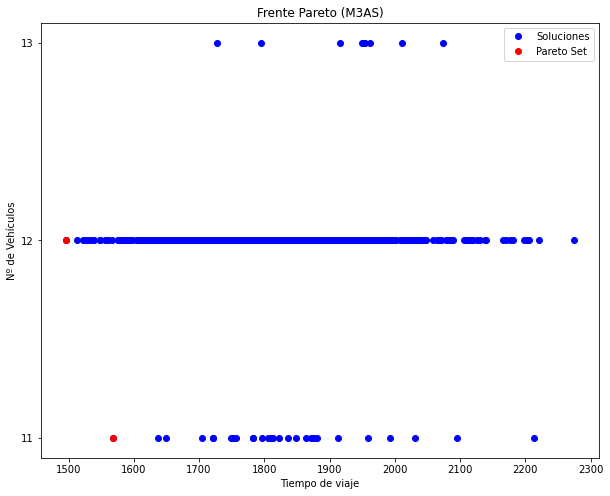

In [42]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from os import makedirs

fig, ax = plt.subplots(figsize=(10, 8))


ax.plot([s.tiempo_total for s in pareto_generacion],
        [s.num_vehiculos for s in pareto_generacion],
        'bo',
        label="Soluciones")

ax.plot([s.tiempo_total for s in pareto_set],
        [s.num_vehiculos for s in pareto_set],
        'ro',
        label="Pareto Set")

ax.set(xlabel="Tiempo de viaje",
       ylabel="Nº de Vehículos",
       title="Frente Pareto (M3AS)")
ax.yaxis.set_major_locator(ticker.MultipleLocator())
ax.legend(loc='upper right')

makedirs("figs", exist_ok=True)
plt.savefig("figs/ParetoSetM3AS.jpg")